In [27]:
import numpy as np
import pandas as pd
import gzip
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import xgboost as xgb

%matplotlib inline

#train, test split
from sklearn.model_selection import train_test_split

#evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## user related features (KBest and SHAP)

In [ ]:
# 처리한 고객고유특성 데이터 읽어오기
with gzip.open('../preprocessed/user_final.pickle','rb') as f:
    user_all = pickle.load(f)

user_all.head()

In [ ]:
user_all.columns

In [30]:
# X, y(독립변수, 종속변수) 설정하기
X = user_all.drop(['is_applied', 'application_id', 'user_id'], axis = 1)
y = user_all['is_applied']

In [31]:
X.shape

(723526, 323)

In [32]:
# feature별 스케일 해주기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state= 777, stratify = y)

### KBest

In [34]:
# KBest로 유의미한 피처들 뽑고 shap value가 그 안에 존재하는 지 확인
from sklearn.feature_selection import SelectKBest
select = SelectKBest(k = 323) #default: f_classif(Compute the ANOVA F-value for the provided sample)

# 특성 선택
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print('X_train.shape', X_train.shape)
print('X_train_selected.shape', X_train_selected.shape)

Features [ 15  22  29  35  36  42  43  46  47  48  50  57  64  71  78  85  92  99
 113 120 126 127 134 141 148 152 155 162 183 190 197 204 211] are constant.
invalid value encountered in divide


X_train.shape (578820, 323)
X_train_selected.shape (578820, 323)


In [ ]:
all_names = X.columns
# 선택된 특성을 표시
mask = select.get_support()
## 선택된 특성(변수)들
selected_names = all_names[mask]
## 선택되지 않은 특성(변수)들
#unselected_names = all_names[~selected_mask]
print('Selected names: ', selected_names)
#print('Unselected names: ', list(unselected_names))

In [36]:
pd.options.display.float_format = '{:.8f}'.format
pvalues = select.pvalues_
sorted_names = all_names[select.pvalues_<0.05].sort_values()

len(sorted_names) #p-value기준 유효한 feature 259개

259

In [ ]:
# 전체 열 이름 표시
pd.set_option('display.max_seq_items', None)
sorted_names

In [45]:
# shap
# 객체 생성 - default model XGBoost로 사용 
xgb_base_user=xgb.XGBClassifier(random_state=777, n_estimator=400, n_jobs=-1, tree_method='gpu_hist', gpu_id=0)

X_train_df = pd.DataFrame(X_train, columns = X.columns)
xgb_base_user.fit(X_train_df, y_train)

[21:46:33] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimator=400,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=777, reg_alpha=0, ...)

In [46]:
y_pred_user = xgb_base_user.predict(X_test)

In [47]:
print(classification_report(y_test, y_pred_user))

              precision    recall  f1-score   support

         0.0       0.68      0.87      0.76     90980
         1.0       0.58      0.30      0.40     53726

    accuracy                           0.66    144706
   macro avg       0.63      0.59      0.58    144706
weighted avg       0.64      0.66      0.63    144706



In [48]:
# f1_score before selecting features from shap
f1_score(y_test, y_pred_user)

0.3984443053970824

### SHAP value 추출

In [49]:
# shap value 뽑기
import shap
explainer = shap.TreeExplainer(xgb_base_user)
shap_values = explainer.shap_values(X_train_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


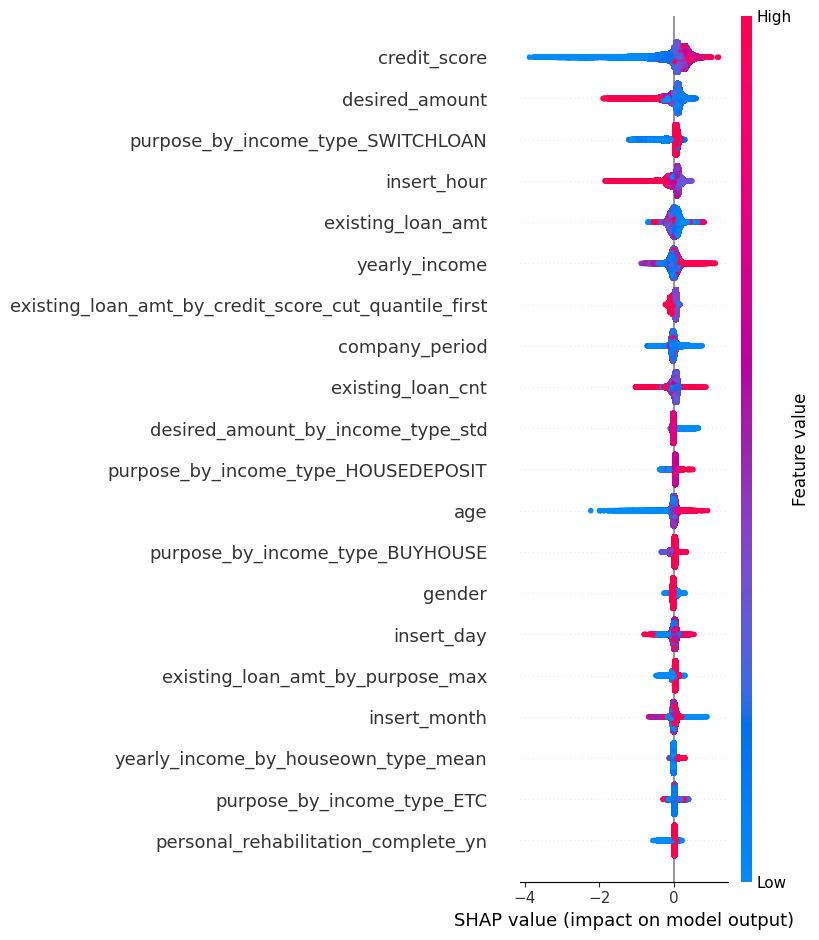

In [50]:
shap.initjs()

shap.summary_plot(shap_values, X_train_df)

In [51]:
# final features for user data (shap): 확인
user_shap = ['income_type', 'employment_type', 'houseown_type', 'purpose',
            'credit_score', 'desired_amount', 'purpose_by_income_type_SWITCHLOAN', 
            'insert_hour', 'existing_loan_amt', 'yearly_income', 'existing_loan_amt_by_credit_score_cut_quantile_first', 
            'company_period', 'existing_loan_cnt', 'income_type', 'desired_amount_by_income_type_std', 
            'existing_loan_amt_by_purpose_max', 'insert_day', 'gender', 'age', 'insert_month', 
            'yearly_income_by_houseown_type_mean', 'purpose_by_income_type_BUYCAR', 'employment_type', 'insert_minute']

len(user_shap)

24

In [52]:
# KBest로 뽑은 변수와 shap으로 뽑은 변수의 길이 차이: 259-24= 237.
# 따라서 shap value 모두가 KBest로 뽑은 변수 안에 있지 않음
len(sorted_names.difference(user_shap))

241

In [53]:
# 아래 네 개 변수(shap으로 뽑은)들은 KBest에 없음
a_sub_b = [x for x in user_shap if x not in sorted_names.intersection(user_shap)]
a_sub_b
# user_shap.difference(set(sorted_names.intersection(user_shap)))

['houseown_type', 'yearly_income', 'company_period', 'insert_minute']

## loan-product related features (KBest and SHAP)

In [ ]:
#데이터 읽어오기
with gzip.open('../preprocessed/loan_final.pickle','rb') as f:
    loan_all = pickle.load(f)

loan_all.head()

In [ ]:
loan_all.dropna(how='any', axis=0, inplace=True)
loan_all

In [6]:
X_loan = loan_all.drop(['is_applied'], axis = 1)
y_loan = loan_all['is_applied']

In [7]:
X_loan.shape

(10132997, 56)

In [8]:
# feature별 스케일 해주기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_loan_scaled=scaler.fit_transform(X_loan)

In [9]:
X_train_loan, X_test_loan, y_train_loan, y_test_loan = train_test_split(X_loan_scaled, y_loan, test_size = 0.2, random_state= 777, stratify = y_loan)

In [10]:
from collections import Counter
# train set 클래스
print(sorted(Counter(y_train_loan).items()))

[(0.0, 7709408), (1.0, 396989)]


In [11]:
# test set 클래스
print(sorted(Counter(y_test_loan).items()))

[(0.0, 1927353), (1.0, 99247)]


### Undersampling (imbalance 해소)

In [12]:
# Random Undersampling
from imblearn.under_sampling import RandomUnderSampler
random_under = RandomUnderSampler()
X_resampled, y_resampled = random_under.fit_resample(X_train_loan, y_train_loan)
display(pd.Series(y_train_loan).value_counts())
display(pd.Series(y_resampled).value_counts())

0.0    7709408
1.0     396989
Name: is_applied, dtype: int64

0.0    396989
1.0    396989
Name: is_applied, dtype: int64

### KBest

In [13]:
from sklearn.feature_selection import SelectKBest
select = SelectKBest(k = 56) #default: f_classif(Compute the ANOVA F-value for the provided sample)

# 특성 선택
select.fit(X_resampled, y_resampled)
X_train_loan_selected = select.transform(X_resampled)
print('X_train.shape', X_resampled.shape)
print('X_train_selected.shape', X_train_loan_selected.shape)

Features [36 42] are constant.
invalid value encountered in divide


X_train.shape (793978, 56)
X_train_selected.shape (793978, 56)


In [ ]:
all_names_loan = X_loan.columns
# 선택된 특성을 표시
mask_loan = select.get_support()
## 선택된 특성(변수)들
selected_names_loan = all_names_loan[mask_loan]
## 선택되지 않은 특성(변수)들
#unselected_names = all_names[~selected_mask]
print('Selected names: ', selected_names_loan)
#print('Unselected names: ', list(unselected_names))

In [15]:
pd.options.display.float_format = '{:.8f}'.format
pvalues = select.pvalues_
sorted_names_loan = all_names_loan[select.pvalues_<0.05].sort_values()

len(sorted_names_loan) #p-value기준 유효한 feature 52개

52

In [ ]:
sorted_names_loan

In [ ]:
X_loan.shape

In [ ]:
X_resampled.shape

### SHAP

In [19]:
# shap
# 객체 생성 - default model 
xgb_base_loan=xgb.XGBClassifier(random_state=777, n_estimator=400, tree_method='gpu_hist', gpu_id=0)

X_resampled_df = pd.DataFrame(X_resampled, columns = X_loan.columns)
xgb_base_loan.fit(X_resampled_df, y_resampled)

[21:24:42] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimator=400,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=777, reg_alpha=0, ...)

In [20]:
y_pred_loan = xgb_base_loan.predict(X_test_loan)
print(classification_report(y_test_loan, y_pred_loan))

              precision    recall  f1-score   support

         0.0       0.99      0.80      0.89   1927353
         1.0       0.19      0.87      0.31     99247

    accuracy                           0.81   2026600
   macro avg       0.59      0.84      0.60   2026600
weighted avg       0.95      0.81      0.86   2026600



In [21]:
f1_score(y_test_loan, y_pred_loan)

0.3065166120133434

In [22]:
import shap
explainer = shap.TreeExplainer(xgb_base_loan)
shap_values = explainer.shap_values(X_resampled_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


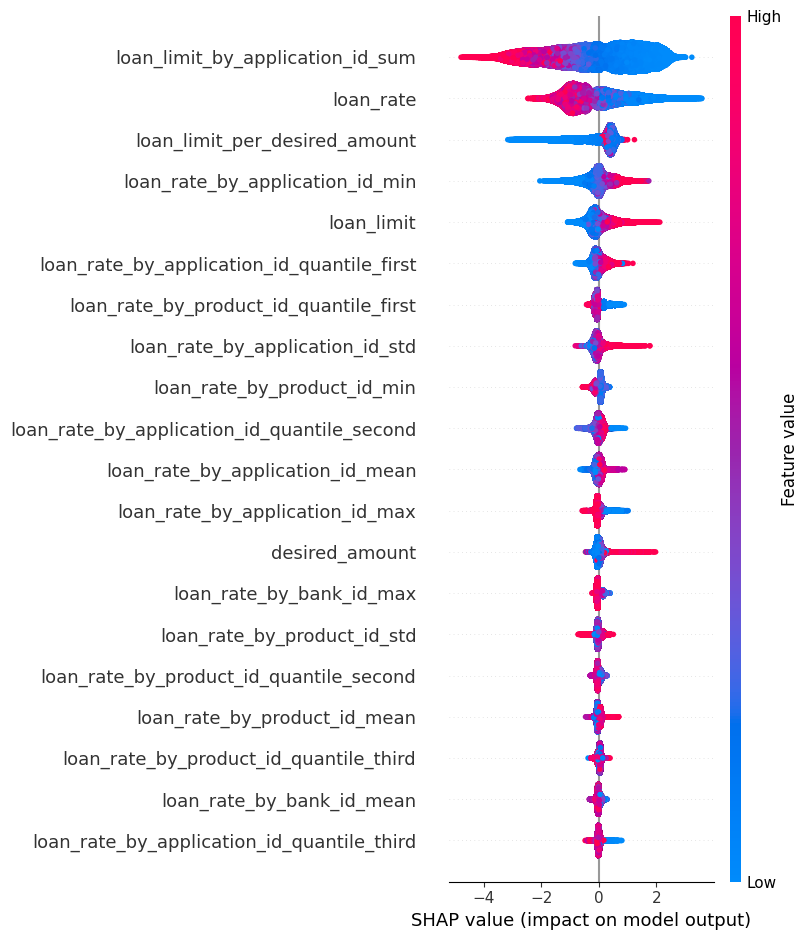

In [23]:
shap.initjs()

shap.summary_plot(shap_values, X_resampled_df)

In [24]:
# 뽑힌 feature 확인
loan_shap = ['loan_limit_by_application_id_sum', 'loan_rate', 'loan_limit_per_desired_amount',
            'loan_rate_by_application_id_min', 'loan_limit', 'loan_rate_by_application_id_quantile_first',
            'loan_rate_by_product_id_quantile_first', 'loan_rate_by_application_id_std', 'loan_rate_by_product_id_min',
            'loan_rate_by_application_id_quantile_second', 'loan_rate_by_application_id_mean',
            'loan_rate_by_application_id_max', 'desired_amount', 'loan_rate_by_bank_id_max', 'loan_rate_by_product_id_std',
            'loan_rate_by_product_id_quantile_second', 'loan_rate_by_product_id_mean', 'loan_rate_by_product_id_quantile_third',
            'loan_rate_by_bank_id_mean', 'loan_rate_by_application_id_quantile_third']
            
len(loan_shap)

20

In [25]:
len(sorted_names_loan.difference(loan_shap))

32

In [26]:
# loan 데이터 같은 경우 shap value로 뽑은 모든 변수들의 KBest의 결과로도 뽑힌다는 결과
a_sub_b = [x for x in loan_shap if x not in sorted_names_loan.intersection(loan_shap)]
a_sub_b

[]